In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import xml.etree.ElementTree as ET
from shutil import copyfile
import os
import os.path as path
import shutil
import pathlib
from pathlib import Path
from tqdm.std import tqdm
import random
import json
import random
import glob
import cv2
import regex as re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import enum
from enum import Enum, auto

import sys

sys.path.insert(0, "..")
from yolo_visualize import sample_yolo_dataset

In [2]:
image_file = Path("./test/s11_front3.png")
data_file = Path("./test/s11_front3.txt")

In [3]:
class BoundingBox:
    class_id: int
    abs_x: int
    abs_y: int
    abs_w: int
    abs_h: int
    min_x: int
    min_y: int
    max_x: int
    max_y: int
    img_w: int
    img_h: int
    area: int

    def __init__(
        self,
        *,
        class_id: int,
        abs_x: int,
        abs_y: int,
        abs_w: int,
        abs_h: int,
        img_w: int,
        img_h: int,
        min_x: int,
        min_y: int,
        max_x: int,
        max_y: int,
    ):
        self.class_id = class_id
        self.abs_x = int(abs_x)
        self.abs_y = int(abs_y)
        self.abs_w = int(abs_w)
        self.abs_h = int(abs_h)
        self.img_w = int(img_w)
        self.img_h = int(img_h)
        self.min_x = int(min_x)
        self.min_y = int(min_y)
        self.max_x = int(max_x)
        self.max_y = int(max_y)
        self.area = abs_w * abs_h
        assert 0 <= abs_x <= img_w
        assert 0 <= abs_y <= img_h
        assert 0 <= abs_w <= img_w
        assert 0 <= abs_h <= img_h
        assert 0 <= min_x <= img_w
        assert 0 <= min_y <= img_h
        assert 0 <= max_x <= img_w
        assert 0 <= max_y <= img_h

    @staticmethod
    def make_from_yolo(*, s: str, img_w: int, img_h: int):
        vs = s.split()
        abs_x = float(vs[1]) * img_w
        abs_y = float(vs[2]) * img_h
        abs_w = float(vs[3]) * img_w
        abs_h = float(vs[4]) * img_h
        min_x = abs_x - abs_w / 2
        min_y = abs_y - abs_h / 2
        max_x = abs_x + abs_w / 2
        max_y = abs_y + abs_h / 2

        return BoundingBox(
            class_id=int(vs[0]),
            abs_x=abs_x,
            abs_y=abs_y,
            abs_w=abs_w,
            abs_h=abs_h,
            img_w=img_w,
            img_h=img_h,
            min_x=min_x,
            min_y=min_y,
            max_x=max_x,
            max_y=max_y,
        )

    @staticmethod
    def make_from_bounds(
        *,
        class_id: int,
        min_x: int,
        min_y: int,
        max_x: int,
        max_y: int,
        img_w: int,
        img_h: int,
    ):
        abs_x = int(min_x + max_x) // 2
        abs_y = int(min_y + max_y) // 2
        abs_w = int(max_x - min_x)
        abs_h = int(max_y - min_y)

        # print("v:", abs_y, img_h)
        return BoundingBox(
            class_id=class_id,
            abs_x=abs_x,
            abs_y=abs_y,
            abs_w=abs_w,
            abs_h=abs_h,
            img_w=img_w,
            img_h=img_h,
            min_x=min_x,
            min_y=min_y,
            max_x=max_x,
            max_y=max_y,
        )

    def crop(self, bound: "BoundingBox"):
        min_x = np.clip(self.min_x - bound.min_x, 0, bound.abs_w)
        min_y = np.clip(self.min_y - bound.min_y, 0, bound.abs_h)
        max_x = np.clip(self.max_x - bound.min_x, 0, bound.abs_w)
        max_y = np.clip(self.max_y - bound.min_y, 0, bound.abs_h)
        # print(
        #     dict(
        #         min_x=min_x,
        #         min_y=min_y,
        #         max_x=max_x,
        #         max_y=max_y,
        #     )
        # )
        return BoundingBox.make_from_bounds(
            class_id=self.class_id,
            min_x=min_x,
            min_y=min_y,
            max_x=max_x,
            max_y=max_y,
            img_w=bound.abs_w,
            img_h=bound.abs_h,
        )

    def to_yolo_str(self):
        x = self.abs_x / self.img_w
        y = self.abs_y / self.img_h
        w = self.abs_w / self.img_w
        h = self.abs_h / self.img_h
        assert 0 <= x <= 1
        assert 0 <= y <= 1
        assert 0 <= w <= 1
        assert 0 <= h <= 1
        return f"{self.class_id} {x} {y} {w} {h}"

    def print_self(self):
        print(
            dict(
                class_id=self.class_id,
                abs_x=self.abs_x,
                abs_y=self.abs_y,
                abs_w=self.abs_w,
                abs_h=self.abs_h,
                img_w=self.img_w,
                img_h=self.img_h,
                min_x=self.min_x,
                min_y=self.min_y,
                max_x=self.max_x,
                max_y=self.max_y,
            )
        )

In [4]:
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

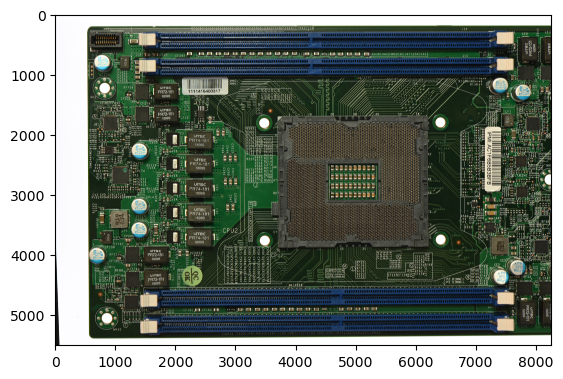

In [5]:
plt.imshow(image)

In [6]:
img_h, img_w = image.shape[:2]
img_w, img_h

(8256, 5504)

In [7]:
with open(data_file, "r") as f:
    boxes = [
        BoundingBox.make_from_yolo(s=line, img_w=img_w, img_h=img_h)
        for line in f.readlines()
    ]

In [8]:
min_box_w = min(box.abs_w for box in boxes)
min_box_h = min(box.abs_h for box in boxes)
min_box_w, min_box_h

(29, 27)

In [9]:
smallest_size_ratio = 0.03  # 3%
ideal_img_w = int(np.ceil(min_box_w / smallest_size_ratio))
ideal_img_h = int(np.ceil(min_box_h / smallest_size_ratio))
ideal_img_w, ideal_img_h

(967, 900)

In [10]:
ideal_overlap_ratio = 0.1
ideal_split_w = ideal_img_w * (1 - ideal_overlap_ratio)
split_w = int(np.ceil(img_w / np.ceil(img_w / ideal_split_w)))
ideal_split_h = ideal_img_h * (1 - ideal_overlap_ratio)
split_h = int(np.ceil(img_h / np.ceil(img_h / ideal_split_h)))
ideal_split_w, ideal_split_h, split_w, split_h

(870.3000000000001, 810.0, 826, 787)

In [11]:
new_box_remove_threshold = 0.6

In [ ]:
image_dir = image_file.parent
data_dir = data_file.parent
image_name = image_file.with_suffix("").name
image_ext = image_file.suffix
total_crops = 0
for min_x in range(0, img_w, split_w):
    for min_y in range(0, img_h, split_h):
        max_x = min(min_x + ideal_img_w, img_w) - 1
        max_y = min(min_y + ideal_img_h, img_h) - 1
        crop_box = BoundingBox.make_from_bounds(
            class_id=-1,
            min_x=min_x,
            min_y=min_y,
            max_x=max_x,
            max_y=max_y,
            img_w=img_w,
            img_h=img_h,
        )
        # crop_box.print_self()
        new_boxes: list[BoundingBox] = []
        for box in boxes:
            # box.print_self()
            new_box = box.crop(crop_box)
            if (new_box.area / box.area) < new_box_remove_threshold:
                continue
            new_boxes.append(new_box)
        if len(new_boxes) == 0:
            continue
        cropped_image = image[min_y : max_y + 1, min_x : max_x + 1]
        Image.fromarray(cropped_image).save(
            image_dir / f"{image_name}-crop-{int(min_x)}-{int(min_y)}{image_ext}"
        )
        with open(
            data_dir / f"{image_name}-crop-{int(min_x)}-{int(min_y)}.txt", "w"
        ) as f:
            for new_box in new_boxes:
                f.write(new_box.to_yolo_str())
                f.write("\n")
        total_crops += 1

print(total_crops)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:23<00:00,  2.38s/it]

51
